In [1]:
!pip -q install git+https://github.com/DevoLearn/CELLSAM.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.6/377.6 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 3.7 MB/s eta 

In [2]:
!pip install gdown

In [3]:
!gdown --id  1u6AitBDdsXVDSf6Pv4W32r5WN3Orx_Co

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1u6AitBDdsXVDSf6Pv4W32r5WN3Orx_Co
To: /content/cellsam_bbox.pth
100% 375M/375M [00:05<00:00, 64.8MB/s]


In [4]:
import gc
import torch
import numpy as np
import cv2
from torch.nn import functional as F
from os import listdir, makedirs, getcwd
from os.path import join, exists, isfile, isdir, basename
from glob import glob
from ipywidgets import interact, widgets, FileUpload
from IPython.display import display
from matplotlib import patches as patches
from matplotlib import pyplot as plt
from copy import deepcopy

def show_mask(mask, ax, random_color=False, alpha=0.95):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


class BboxPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        self.gt = None
        self.currently_selecting = False
        self.x0, self.y0, self.x1, self.y1 = 0., 0., 0., 0.
        self.rect = None
        self.fig, self.axes = None, None
        self.segs = []

    def _show(self, fig_size=5, random_color=True, alpha=0.65):
        assert self.image is not None, "Please set image first."

        self.fig, self.axes = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False
        self.fig.canvas.toolbar_visible = False
        self.fig.canvas.resizable = False

        plt.tight_layout()
        self.axes.imshow(self.image)
        self.axes.axis('off')

        def __on_press(event):
            if event.inaxes == self.axes:
                self.x0 = float(event.xdata)
                self.y0 = float(event.ydata)
                self.currently_selecting = True
                self.rect = plt.Rectangle(
                    (self.x0, self.y0),
                    1,1, linestyle="--",
                    edgecolor="crimson", fill=False
                )
                self.axes.add_patch(self.rect)
                self.rect.set_visible(False)

        def __on_release(event):
            if event.inaxes == self.axes:
                if self.currently_selecting:
                    self.x1 = float(event.xdata)
                    self.y1 = float(event.ydata)
                    self.fig.canvas.draw_idle()
                    self.currently_selecting = False
                    self.rect.set_visible(False)
                    self.axes.patches[0].remove()
                    x_min = min(self.x0, self.x1)
                    x_max = max(self.x0, self.x1)
                    y_min = min(self.y0, self.y1)
                    y_max = max(self.y0, self.y1)
                    bbox = np.array([x_min, y_min, x_max, y_max])
                    with torch.no_grad():
                        seg = self._infer(bbox)
                        torch.cuda.empty_cache()
                    show_mask(seg, self.axes, random_color=random_color, alpha=alpha)
                    self.segs.append(deepcopy(seg))
                    del seg
                    self.rect = None
                    gc.collect()

        def __on_motion(event):
            if event.inaxes == self.axes:
                if self.currently_selecting:
                    self.x1 = float(event.xdata)
                    self.y1 = float(event.ydata)
                    #add rectangle for selection here
                    self.rect.set_visible(True)
                    xlim = np.sort([self.x0, self.x1])
                    ylim = np.sort([self.y0, self.y1])
                    self.rect.set_xy((xlim[0],ylim[0] ) )
                    rect_width = np.diff(xlim)[0]
                    self.rect.set_width(rect_width)
                    rect_height = np.diff(ylim)[0]
                    self.rect.set_height(rect_height)

        clear_button = widgets.Button(description="clear")
        def __on_clear_button_clicked(b):
            for i in range(len(self.axes.images)):
                self.axes.images[0].remove()
            self.axes.clear()
            self.axes.axis('off')
            self.axes.imshow(self.image)
            if len(self.axes.patches) > 0:
                self.axes.patches[0].remove()
            self.segs = []
            self.fig.canvas.draw_idle()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if len(self.segs) > 0:
                save_seg = np.zeros_like(self.segs[0])
                for i, seg in enumerate(self.segs, start=1):
                    save_seg[seg > 0] = i
                cv2.imwrite("segs.png", save_seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(clear_button)
        clear_button.on_click(__on_clear_button_clicked)

        self.fig.canvas.mpl_connect('button_press_event', __on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', __on_motion)
        self.fig.canvas.mpl_connect('button_release_event', __on_release)

        plt.show()

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def show(self, image_path, fig_size=5, random_color=True, alpha=0.65):
        self.set_image_path(image_path)
        self._show(fig_size=fig_size, random_color=random_color, alpha=alpha)

    def set_image_path(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self._set_image(image)

    def _set_image(self, image):
        self.image = image
        self.img_size = image.shape[:2]
        image_preprocess = self._preprocess_image(image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)

    def _preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor

    @torch.no_grad()
    def _infer(self, bbox):
        ori_H, ori_W = self.img_size
        scale_to_1024 = 1024 / np.array([ori_W, ori_H, ori_W, ori_H])
        bbox_1024 = bbox * scale_to_1024
        bbox_torch = torch.as_tensor(bbox_1024, dtype=torch.float).unsqueeze(0).to(self.model.device)
        if len(bbox_torch.shape) == 2:
            bbox_torch = bbox_torch.unsqueeze(1)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=bbox_torch,
            masks=None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings = self.image_embeddings, # (B, 256, 64, 64)
            image_pe = self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings = sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )

        low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

        low_res_pred = F.interpolate(
            low_res_pred,
            size=self.img_size,
            mode="bilinear",
            align_corners=False,
        )  # (1, 1, gt.shape)
        low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
        cellsam_seg = (low_res_pred > 0.5).astype(np.uint8)
        return cellsam_seg

In [6]:
%matplotlib widget
from segment_anything import sam_model_registry
CellSAM_CKPT_PATH = "/content/cellsam_bbox.pth"
device = "cuda:0"
cellsam_model = sam_model_registry['vit_b'](checkpoint=CellSAM_CKPT_PATH)
cellsam_model = cellsam_model.to(device)
cellsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [7]:
from google.colab import output
output.enable_custom_widget_manager()


Button(description='clear', style=ButtonStyle())

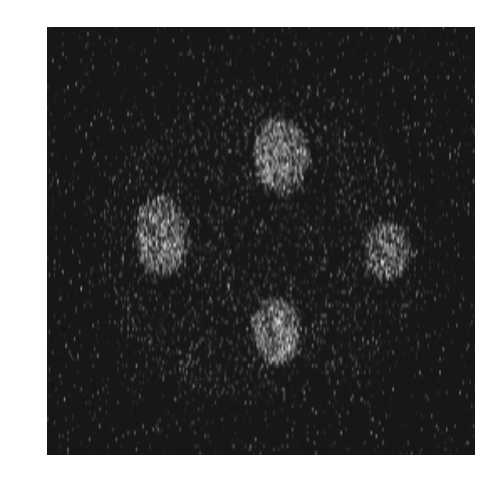

Button(description='save', style=ButtonStyle())

In [9]:
img = "/content/seg_result.png"
bbox_prompt_demo = BboxPromptDemo(cellsam_model)
bbox_prompt_demo.show(img)